In [ ]:
!pip install qwen-vl-utils optimum auto-gptq

In [ ]:
!pip install flash-attn --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.7.2.post1-cp310-cp310-linux_x86_64.whl size=190160474 sha256=0b454d9e650bfc437cc71335080172a5d05f51eab355636c9d5b7321fec7318e
  Stored in directory: /root/.cache/pip/wheels/da/ec/5b/b2c37a8e4f755ad82492a822463bca0817f0e0e11de874b550
Successfully built flash-attn


In [ ]:
import torch
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

# default: Load the model on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", torch_dtype="auto", device_map="auto"
)

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = Qwen2VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2-VL-7B-Instruct-GPTQ-Int4",
#     torch_dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

# default processer
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct-GPTQ-Int4")

# The default range for the number of visual tokens per image in the model is 4-16384. You can set min_pixels and max_pixels according to your needs, such as a token count range of 256-1280, to balance speed and memory usage.
min_pixels = 256*28*28
max_pixels = 800*28*28
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct-GPTQ-Int4", min_pixels=min_pixels, max_pixels=max_pixels)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

In [ ]:
first_shot_image = '/content/first.png'
first_shot_tree = '''#42->#44
#42->#47
#42->#50
#50->#53
#53->#54
#53->#55
#53->#56
#50->#58'''

inference_image = '/content/inference.png'

In [ ]:
import cv2


def resize(img, max_side=640):
    f1 = max_side / img.shape[1]
    f2 = max_side / img.shape[0]
    f = min(f1, f2)  # resizing factor
    dim = (int(img.shape[1] * f), int(img.shape[0] * f))
    resized = cv2.resize(img, dim)
    return resized


cv2.imwrite(
    'first_res.jpg',
    resize(cv2.imread(first_shot_image), 800),
)
cv2.imwrite(
    'inference_res.jpg',
    resize(cv2.imread(inference_image), 800),
)
cv2.imread('first_res.jpg').shape, cv2.imread('inference_res.jpg').shape

((800, 368, 3), (800, 372, 3))

In [ ]:
messages = [
    {
        "role": "system",
        "content": "You are documnets parsing bot. Use graph edges representation #parent-id->#child-id",
    },
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": (
                    "Your task is to determinate paragraphs dependencies to build tree sctructure from document page using next rules:\n"
                    "1. Higher level header is a parent of lower level header.\n"
                    "2. Regular text paragraph is a child of last header above.\n"
                    "3. Higher level list item is parent of lower level sublist item.\n"
                    "3. Paragraphs with numeration are parents for paragraphs without it bellow.\n"
                    "Use graph edges representation #parent-id->#child-id"
                )
            }
        ]
    },
    {"role": "assistant", "content": 'Ok, I understand'},
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": 'first_res.jpg',
            },
            {"type": "text", "text": "Let's try. Write image content as graph. Use IDs in right of of text bboxes"},
        ],
    },
    {"role": "assistant", "content": first_shot_tree},
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": 'inference_res.jpg',
            },
            {"type": "text", "text": "Perfect! Let's try next. Write image content as graph. Use IDs in right of of text bboxes"}
        ],
    },
]

# messages = [
#     {
#         "role": "system",
#         "content": "You are documnets parsing bot. Use graph edges representation #parent-id->#child-id",
#     },
#     {
#         "role": "user",
#         "content": [
#             {
#                 "type": "text",
#                 "text": (
#                     "Your task is to determinate paragraphs dependencies to build tree sctructure from document page using next rules:\n"
#                     "1. Higher level header is a parent of lower level header.\n"
#                     "2. Regular text paragraph is a child of last header above.\n"
#                     "3. Higher level list item is parent of lower level sublist item.\n"
#                     "4. Paragraphs with numeration are parents for paragraphs without it bellow.\n"
#                     "Text spans are graph nodes. Use graph edges representation #parent-id -> #child-id. Like this example:\n"
#                     "```\n"
#                     "#1 -> #2\n"
#                     "#1 -> #3\n"
#                     "#3 -> #7\n"
#                     "#3 -> #9\n"
#                     "...\n"
#                     "```\n"
#                     "Write page content from image as a graph. Use IDs in right of of text bboxes"
#                 )
#             },
#             {
#                 "type": "image",
#                 "image": 'first_res.jpg',
#             },
#         ]
#     }
# ]

# messages = [
#     {
#         "role": "system",
#         "content": "You are documnets find-grained OCR bot",
#     },
#     {
#         "role": "user",
#         "content": [
#             {
#                 "type": "text",
#                 "text":  "Write text from bbox with id #53"
#             },
#             {
#                 "type": "image",
#                 "image": 'first_res.jpg',
#             },
#         ]
#     }
# ]

In [ ]:
# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")
inputs['input_ids'].shape, inputs['pixel_values'].shape

(torch.Size([1, 994]), torch.Size([3016, 1176]))

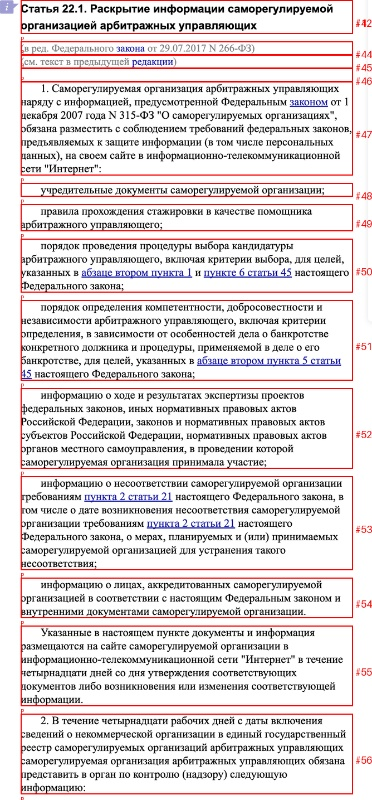

In [ ]:
from PIL import Image

Image.open('inference_res.jpg')

In [ ]:
# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=256)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)


In [ ]:
print(output_text[0])

# Статья 22. Раскрытие информации саморегулируемой организацией арбитражных управляющих

1. Саморегулируемая организация арбитражных управляющих наряду с информацией, предусмотренной Федеральным законом от 1 декабря 2007 года N 315-ФЗ "О саморегулируемых организациях", обязана разместить с соблюдением требований федеральных законов, предъявляемых к защите информации (в том числе персональных данных), на своем сайте в информационно-телекоммуникационной сети "Интернет":

учредительные документы саморегулируемой организации;

правила прохождения процедуры выбора кандидатуры арбитражного управляющего, включая критерии выбора, для целей, указанных в абзаце втором пункта 1 и пункте 6 статьи 45 настоящего Федерального закона;

порядок проведения процедуры выбора кандидат
